In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataManager import dataManager
from itertools import product
import os
import seaborn as sns
import xarray
myData = dataManager("resetting","simplePotentials1")

# 1D

## The potential:

$V(x) = Ax^2+B exp\left(-\frac{x^2}{2C^2}\right)$

Text(0, 0.5, 'V(x) ($k_BT$)')

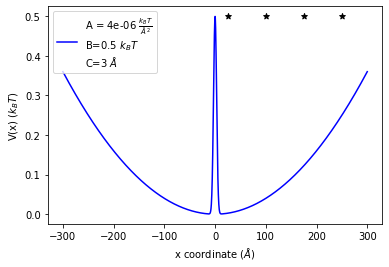

In [113]:
xs = np.linspace(-300,300,2000)
A = 1e-9/0.00025
B = 0.5
C = 3
startPoints = [25,100,175,250]
potential = (A*(abs(xs)**2)+B*np.exp(-0.5*xs**2/(C**2)))
plt.plot(xs,potential,c="blue",label=f"A = {A} "+r"$\frac{k_BT}{\AA^2}$"+"\n"+fr"B={B} $k_BT$"+"\n"+f"C={C} $\AA$")
for x in startPoints:
    plt.scatter(x, 0.5, marker="*", c="black")
plt.legend()
plt.xlabel("x coordinate ($\AA$)")
plt.ylabel("V(x) ($k_BT$)")

## First passage distribution

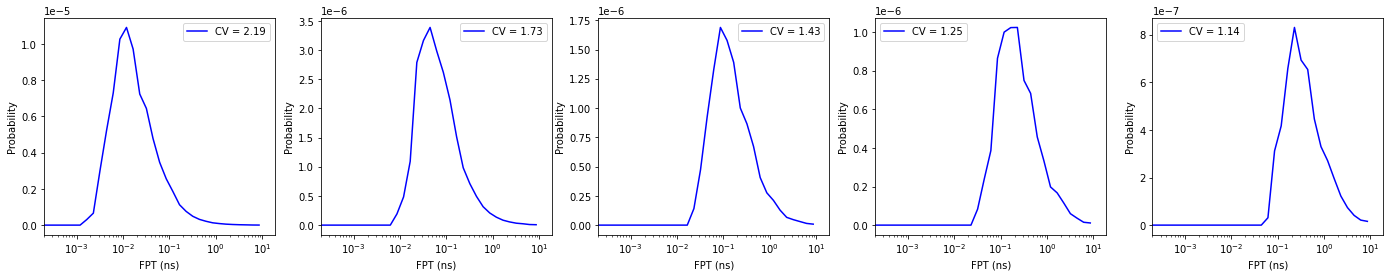

In [75]:
fig, axs = plt.subplots(1,5,figsize=(24,4))
for i in range(5):
    doc = myData.collection.find_one(dict(dimensions=1, tails=A*0.00025, height=B*0.00025, width=C**2, start=startPoints[i], restartRate=0, dataType="FPT"))
    fpts = np.loadtxt(doc["path"],skiprows=1)
    logbins = np.logspace(0,np.log10(max(fpts)),50)
    xs = 0.5*(logbins[1:] + logbins[:-1])
    c,b = np.histogram(fpts, bins=logbins, density=True)
    axs[i].plot(xs/1e6,c,c="blue",label=f"CV = {format(fpts.std()/fpts.mean(),'.2f')}")
    axs[i].legend()
    axs[i].set_xscale("log")
    axs[i].set_ylabel("Probability")
    axs[i].set_xlabel("FPT (ns)")
    axs[i].set_xlim(0.0002)

## Improvement factor

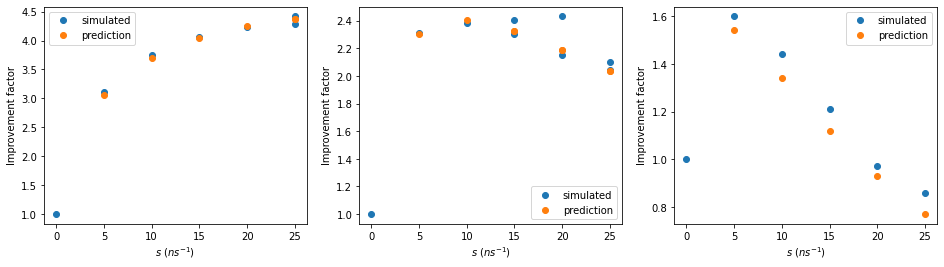

In [62]:
fig, axs = plt.subplots(1,3,figsize=(16,4))
for i in range(3):
    datalist = []
    for doc in myData.collection.find(dict(dimensions=1, tails=A*0.00025, height=B*0.00025, width=C**2, start=startPoints[i], dataType="FPT")):
        fpts = np.loadtxt(doc["path"],skiprows=1)
        datalist.append(pd.DataFrame({"rate":doc["restartRate"],"Mean":[fpts.mean()]}))
    data = pd.concat(datalist)
    data["factor"] = data.loc[data.rate==0].Mean/data.Mean
    axs[i].plot(data.rate*1e6,data.factor,"o",label = "simulated")

    doc = myData.collection.find_one(dict(dimensions=1, tails=A*0.00025, height=B*0.00025, width=C**2, start=startPoints[i], restartRate=0, dataType="FPT"))
    fpts = np.loadtxt(doc["path"],skiprows=1)
    predictions = []
    for rate in data.loc[data.rate!=0].rate:
        Tr = sum(np.exp(-rate*fpts))/len(fpts)
        predictions.append((1-Tr)/(Tr*rate))
    axs[i].plot(data.loc[data.rate!=0].rate*1e6,fpts.mean()/np.array(predictions),"o",label="prediction")
    axs[i].legend()
    axs[i].set_xlabel(r"$s$ $(ns^{-1})$")
    axs[i].set_ylabel("Improvement factor")

# 2D

## The potential:

$V(x',y') = A(x'^4+y'^4-2x'^2-4y'^2+x'y'+0.3x'+0.1y')$\
$x'=\frac{x}{B},y'=\frac{y}{C}$

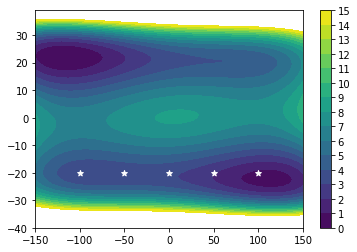

In [105]:
# list(myData.collection.find(dict(dimensions=2, dataType="FPT",restartRate=0.5e-5)))
xs = [-150.00000001 + i for i in range(301)]
ys = [-40.000000001 + i for i in range(80)]
A = 0.0003/0.00025
B = 100
C = 15
startPoints = [-100,-50,0,50,100]

levels=[i for i in range(16)]
datalist = []
for xtag in xs:
    x = xtag/B
    newRow = []
    for ytag in ys:
        y = ytag/C
        newRow.append(A*(x**4+y**4-2*x**2-4*y**2+x*y+0.3*x+0.1*y))
    datalist.append(pd.DataFrame({"x":xtag,"y":ys,"V":newRow}))
surface = pd.concat(datalist).reset_index()
surface.V -= surface.V.min() 
plt.tricontourf(surface.x,surface.y,surface.V,levels=levels)
cbar = plt.colorbar(ticks=levels)
for point in startPoints:
    plt.scatter(point,-20,c="white",marker="*")

## First passage distribution

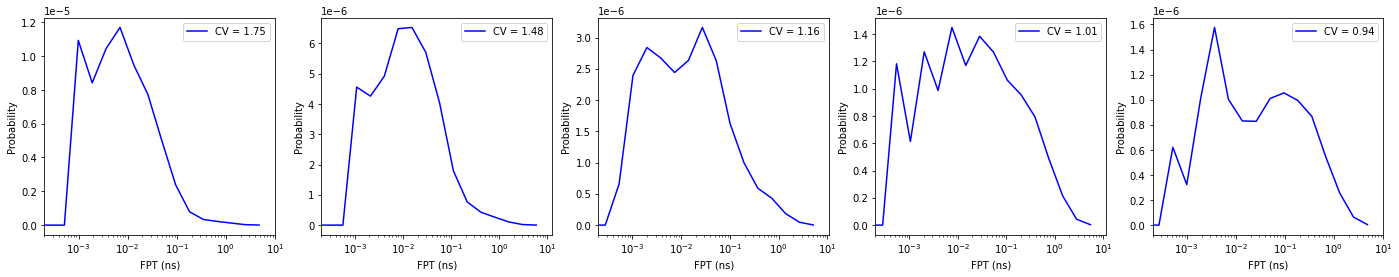

In [106]:
fig, axs = plt.subplots(1,5,figsize=(24,4))
for i in range(5):
    doc = myData.collection.find_one(dict(dimensions=2,startx=startPoints[i],amplitude=0.0003,stretchy=15,restartRate=0,potential='WolfeQuapp', dataType="FPT"))
    fpts = np.loadtxt(doc["path"],skiprows=1)
    logbins = np.logspace(0,np.log10(max(fpts)),25)
    xs = 0.5*(logbins[1:] + logbins[:-1])
    c,b = np.histogram(fpts, bins=logbins, density=True)
    axs[i].plot(xs/1e6,c,c="blue",label=f"CV = {format(fpts.std()/fpts.mean(),'.2f')}")
    axs[i].legend()
    axs[i].set_xscale("log")
    axs[i].set_ylabel("Probability")
    axs[i].set_xlabel("FPT (ns)")
    axs[i].set_xlim(0.0002)

## Improvement factor

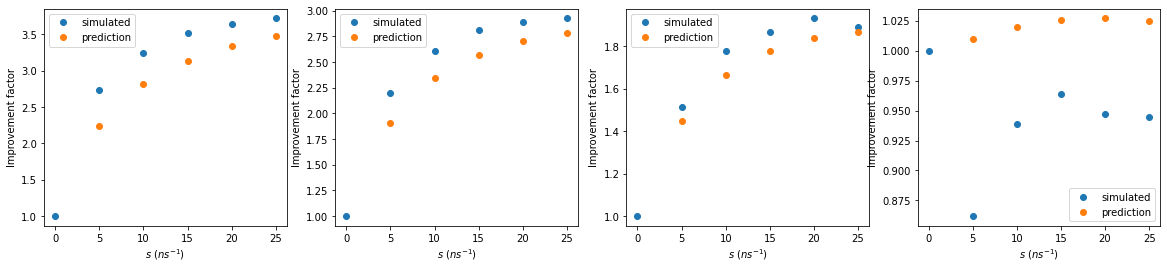

In [107]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
for i in range(4):
    datalist = []
    for doc in myData.collection.find(dict(dimensions=2,startx=startPoints[i],amplitude=0.0003,stretchy=15,potential='WolfeQuapp', dataType="FPT")):
        fpts = np.loadtxt(doc["path"],skiprows=1)
        datalist.append(pd.DataFrame({"rate":doc["restartRate"],"Mean":[fpts.mean()]}))
    data = pd.concat(datalist)
    data = data.drop_duplicates("rate")
    data["factor"] = data.loc[data.rate==0].Mean/data.Mean
    axs[i].plot(data.rate*1e6,data.factor,"o",label = "simulated")

    doc = myData.collection.find_one(dict(dimensions=2,startx=startPoints[i],amplitude=0.0003,stretchy=15,restartRate=0,potential='WolfeQuapp', dataType="FPT"))
    fpts = np.loadtxt(doc["path"],skiprows=1)
    predictions = []
    for rate in data.loc[data.rate!=0].rate:
        Tr = sum(np.exp(-rate*fpts))/len(fpts)
        predictions.append((1-Tr)/(Tr*rate))
    axs[i].plot(data.loc[data.rate!=0].rate*1e6,fpts.mean()/np.array(predictions),"o",label="prediction")
    axs[i].legend()
    axs[i].set_xlabel(r"$s$ $(ns^{-1})$")
    axs[i].set_ylabel("Improvement factor")

In [108]:
doc

{'_id': ObjectId('62aeda1e7d2b0b54118894f5'),
 'path': '/home/ofirblumer/Projects/resetting/results/FPTs8282350093658065',
 'fileSeed': '8282350093658065',
 'stretchx': 100.0,
 'stretchy': 15.0,
 'amplitude': 0.0003,
 'restartRate': 0.0,
 'gamma': 0.01,
 'simSeed': 30003,
 'thermostat': 'CSVR',
 'startx': 50.0,
 'starty': -20.0,
 'mass': 1,
 'potential': 'WolfeQuapp',
 'project': 'resetting',
 'dimensions': 2,
 'N': 4890,
 'dataType': 'FPT'}